# T cell Clustering 
## Modality : Flow Cytometry

In [1]:
import scyan as sy
import os
import glob
import anndata
import re
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
import numpy as np
import scanpy as sc
import scanpy.external as sce
import scipy.sparse
import seaborn as sns
import plotly as py
import plotly.graph_objects as go
import plotly.express as px
print(sy.__version__)
print(anndata.__version__)

/home/jupyter/libs/py_scrna/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 0


1.6.2
0.10.8


In [ ]:
## reading the scFlow T cell object

In [2]:
PT1=sc.read("/home/jupyter/ALTRA_ANALYSIS/Certprod/input_files/cache/b598fdc7-7aae-4cf7-9304-bdb85a117815/adata_leiden_scaled_harmonized_umap_downsmpl_celltypes_total_t_cells_PT1.h5ad")

In [3]:
PT1

AnnData object with n_obs × n_vars = 5480000 × 25
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'l1_labels', 'sample.sampleKitGuid', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023', 'leiden_res_2', 'leiden_res_2.5', 'leiden_res_3'
    var: 'antigens', 'gating_antigens', 'highly_variable'
    uns: 'neighbors', 'pca', 'scyan_scaling_means', 'scyan_scaling_stds'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
PT1.obs['leiden_res_2'].value_counts()

leiden_res_2
0     477812
1     429253
2     398308
3     377990
4     362027
5     348421
6     297894
7     274855
8     256983
9     254885
10    233866
11    201583
12    193924
13    193160
14    176021
15    161755
16    144156
17    112289
18    112032
19    107886
20     75378
21     64267
22     55596
23     34324
24     34282
25     33838
26     31239
27     14431
28     11632
29      8613
30      1095
31       120
32        85
Name: count, dtype: int64

In [7]:
PT1.obs['C0_C4_vs_other'] = PT1.obs['leiden_res_2'].apply(lambda x: x if x in ['0', '4'] else 'other_clusters')


In [8]:
PT1.obs['C0_C4_vs_other'].value_counts()

C0_C4_vs_other
other_clusters    4640161
0                  477812
4                  362027
Name: count, dtype: int64

In [14]:
#subetting lables
PT1_labls_df = PT1.obs[['barcode', 'labels','C0_C4_vs_other']]
PT1_labls_df.shape

(5480000, 3)

In [15]:
PT1.obs.set_index('barcode', drop=False, inplace=True)

In [16]:
PT1_labls_df.head()

,barcode,labels,C0_C4_vs_other
37130704,40a4833833d811eda6b6f66977b44e60,naive_cd4_t_cells,other_clusters
36801572,3e6b582633d811eda6b6f66977b44e60,cm_cd4_t_cells,other_clusters
37084835,406f7b1633d811eda6b6f66977b44e60,em_cd4_t_cells,other_clusters
36967259,3fe3465033d811eda6b6f66977b44e60,cm_cd4_t_cells,other_clusters
36866191,3eb7eb6433d811eda6b6f66977b44e60,naive_treg,other_clusters


In [17]:
if scipy.sparse.issparse(PT1.X):
    count_matrix = PT1.X.toarray()
else:
    count_matrix = PT1.X

# Create a DataFrame from the count matrix
df = pd.DataFrame(count_matrix, index=PT1.obs.index, columns=PT1.var.index)

df.shape

(5480000, 25)

In [18]:
merged_df = pd.merge(df, PT1_labls_df, on='barcode')
merged_df.shape

(5480000, 28)

In [19]:
merged_df.head(3)

,barcode,CD3_logicle,CD45_logicle,CD56_logicle,CD19_logicle,CD27_logicle,CD8_logicle,CD39_logicle,CD103_logicle,abTCR_logicle,...,HLA-DR_logicle,CD279 (PD-1)_logicle,TIGIT_logicle,CD38_logicle,CD197 (CCR7)_logicle,CD69_logicle,CD25 (IL2Ra)_logicle,KLRG1_logicle,labels,C0_C4_vs_other
0,40a4833833d811eda6b6f66977b44e60,-1.405826,-0.066232,-0.334763,-0.476543,0.417468,-0.309581,1.001104,0.853448,-0.857383,...,0.382502,-0.794245,-0.710868,0.070150,0.886310,-1.660223,-0.111165,-0.695706,naive_cd4_t_cells,other_clusters
1,3e6b582633d811eda6b6f66977b44e60,0.790383,0.664620,-0.299718,0.105425,0.747334,-0.020505,0.864152,0.473550,0.188373,...,0.427079,-0.862980,1.169814,0.347720,0.661261,-1.991725,0.543625,-0.631786,cm_cd4_t_cells,other_clusters
2,406f7b1633d811eda6b6f66977b44e60,0.484668,0.205523,-0.293854,-0.428844,-0.514898,-0.415754,0.309270,-0.204881,0.027951,...,1.747632,2.011243,0.140676,-1.858394,-1.713988,-0.483708,1.730649,-0.437135,em_cd4_t_cells,other_clusters


In [21]:
merged_df.columns

Index(['barcode', 'CD3_logicle', 'CD45_logicle', 'CD56_logicle',
       'CD19_logicle', 'CD27_logicle', 'CD8_logicle', 'CD39_logicle',
       'CD103_logicle', 'abTCR_logicle', 'CD223 (LAG3)_logicle',
       'CD95_logicle', 'CD127 (IL7Ra)_logicle', 'CD278 (ICOS)_logicle',
       'CD45RA_logicle', 'CD185 (CXCR5)_logicle', 'CD14_logicle',
       'CD4_logicle', 'HLA-DR_logicle', 'CD279 (PD-1)_logicle',
       'TIGIT_logicle', 'CD38_logicle', 'CD197 (CCR7)_logicle', 'CD69_logicle',
       'CD25 (IL2Ra)_logicle', 'KLRG1_logicle', 'labels', 'C0_C4_vs_other'],
      dtype='object')

In [9]:
fig_path='/home/jupyter/ALTRA_ANALYSIS/Certprod/Figures/PT1/'
figsize = (4,4)
sc.settings.figdir = fig_path
sc.settings.autosave=False
sc.set_figure_params(vector_friendly=True, dpi_save=300)
plt.figure(figsize=figsize)

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

/home/jupyter/libs/py_scrna/lib/python3.12/site-packages/scyan/plot/_scanpy_plot/umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


<Figure size 320x320 with 0 Axes>

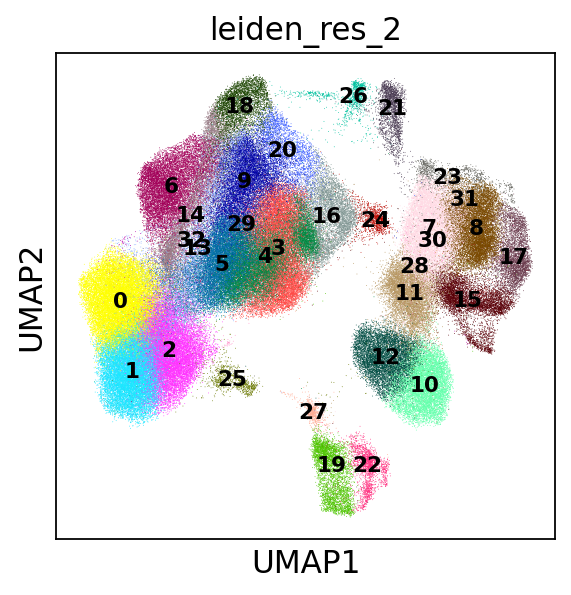

In [11]:
# Create a figure
plt.figure(figsize=figsize)

# Plot the UMAP with Scanpy
p1=sy.plot.umap(PT1, color=["leiden_res_2"], vmax='p95', vmin='p05', 
             show=False, legend_loc='on data', legend_fontsize='x-small')

# Save the figure to the specified path
plt.savefig(f"{fig_path}umap_leiden_res1_PT1.pdf", dpi=300)

# Display the figure
plt.show()

/home/jupyter/libs/py_scrna/lib/python3.12/site-packages/scyan/plot/_scanpy_plot/umap.py:884: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


<Figure size 320x320 with 0 Axes>

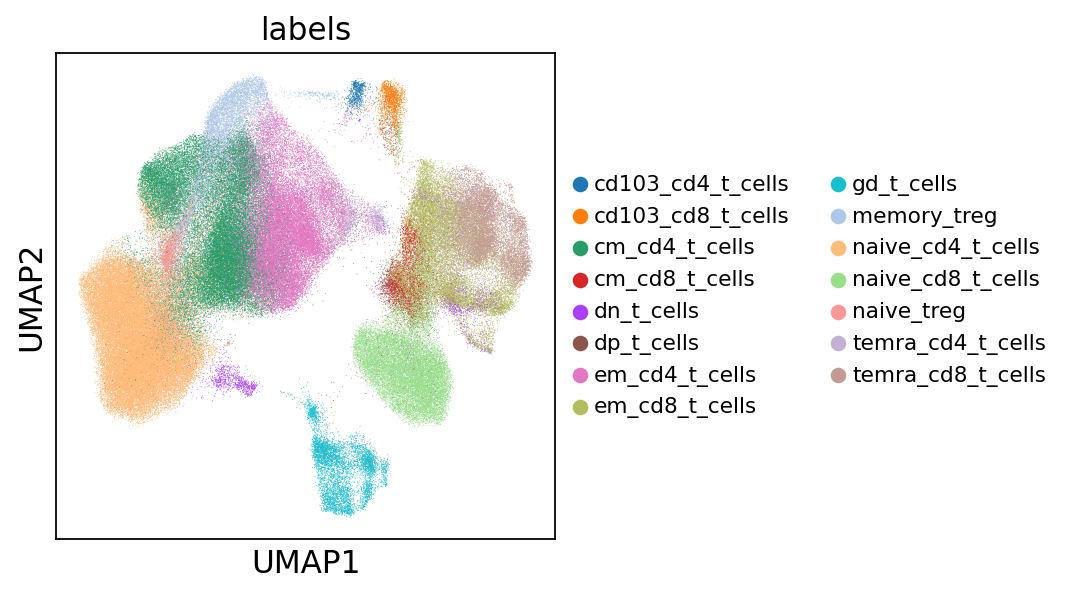

In [12]:

# Create a figure
plt.figure(figsize=figsize)

# Plot the UMAP with Scanpy
p1=sy.plot.umap(PT1, color=["labels"], vmax='p95', vmin='p05', 
             show=False,## if set true pdf/png is empty
                #legend_loc='on data', 
                legend_fontsize='x-small')

# Save the figure to the specified path
plt.savefig(f"{fig_path}umap_cyanno_labels_PT1.pdf", dpi=300,bbox_inches='tight')

# Display the figure
plt.show()

<Figure size 320x320 with 0 Axes>

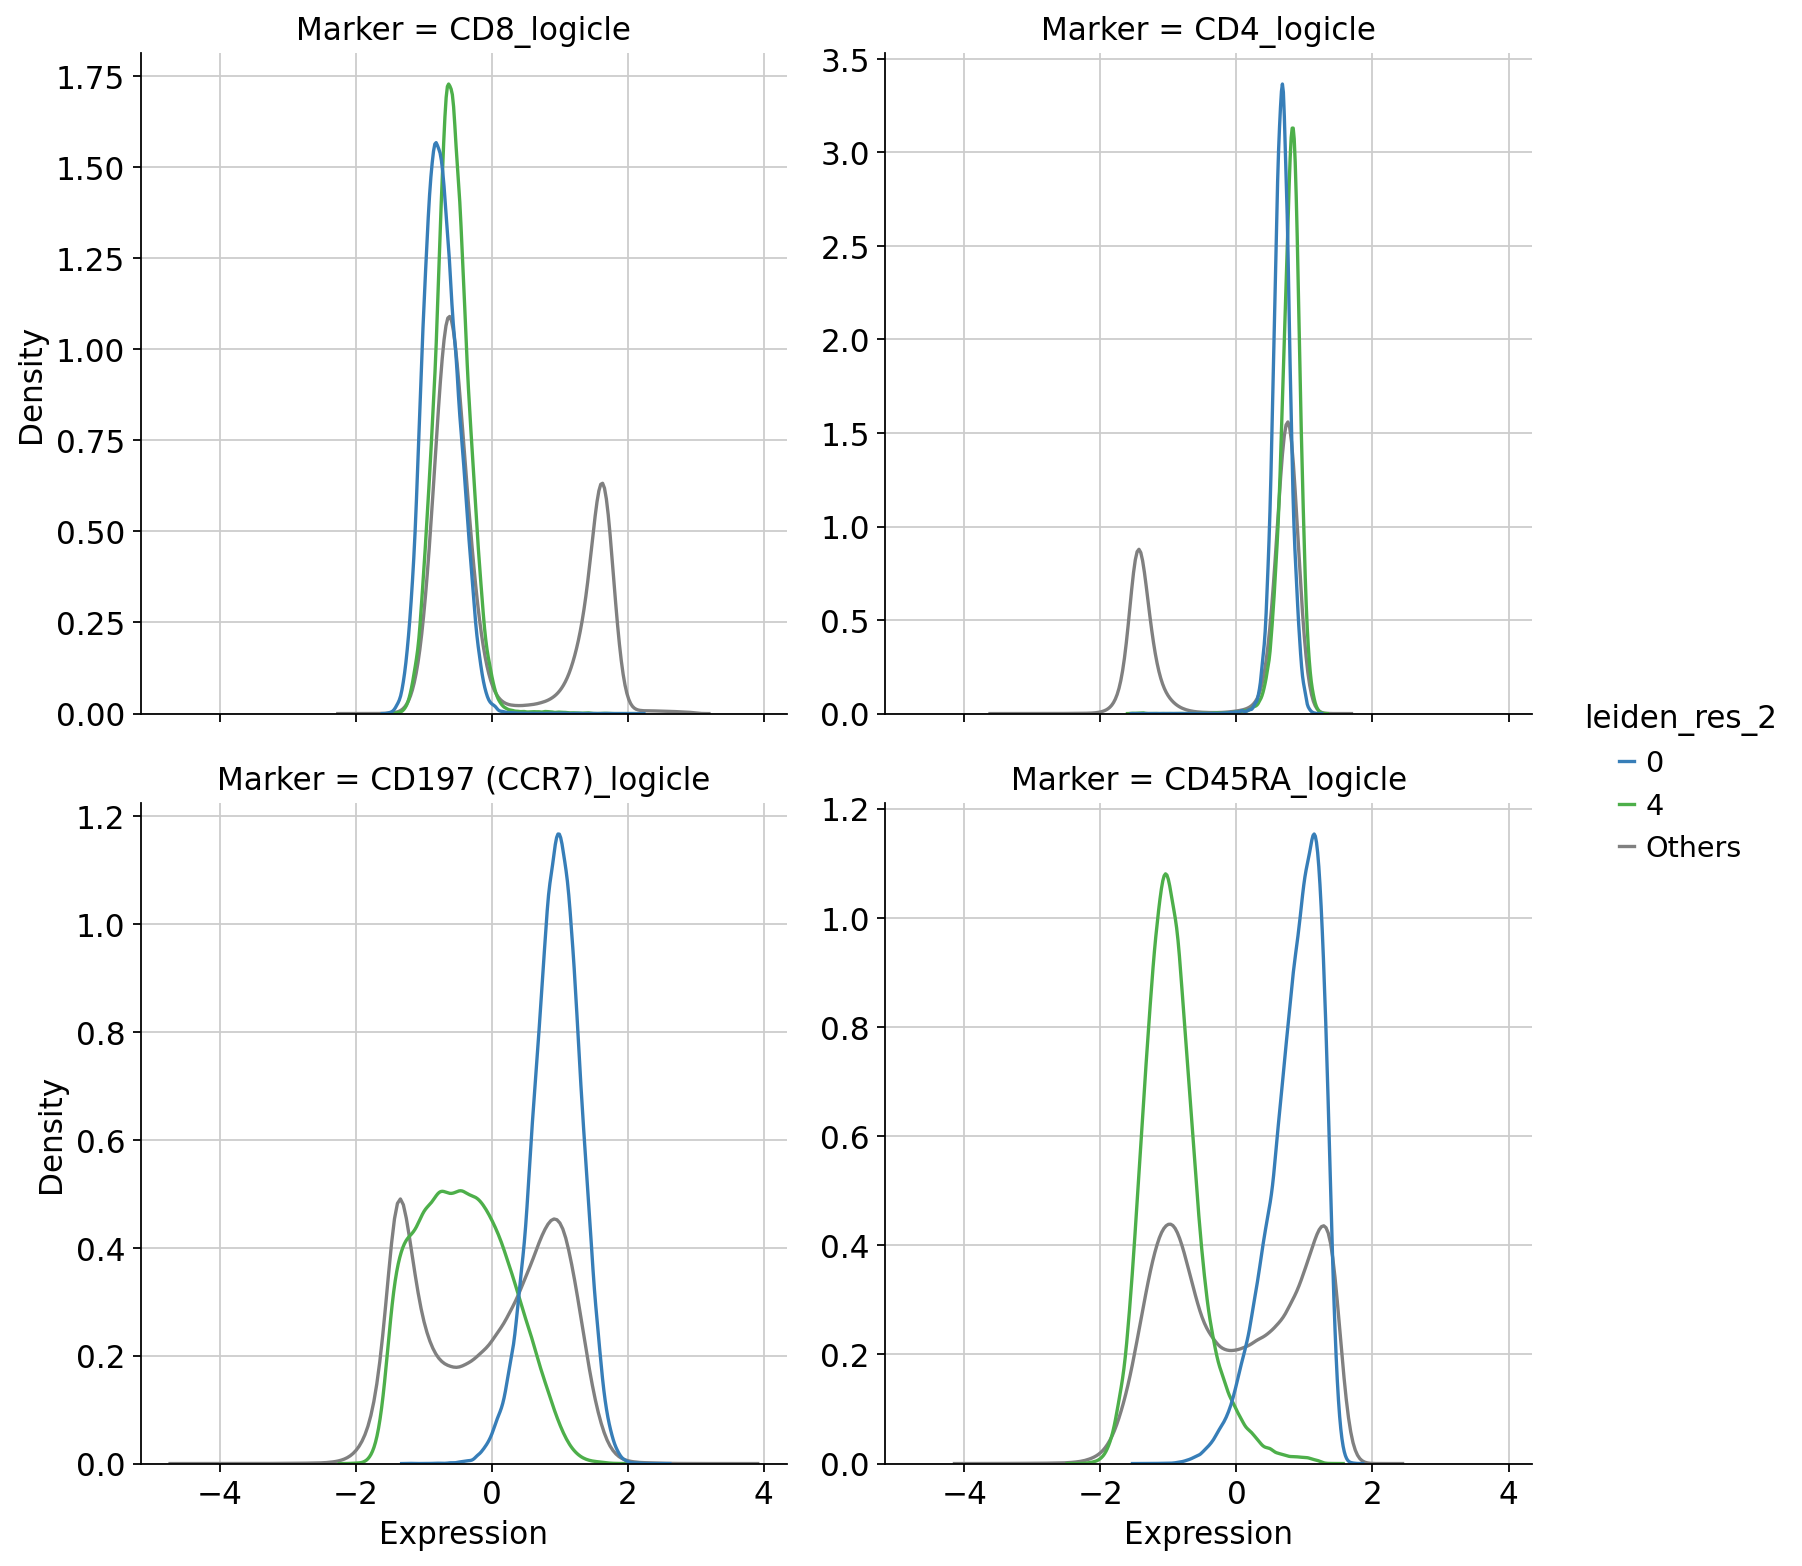

In [25]:
plt.figure(figsize=figsize)
sy.plot.kde(PT1,key='leiden_res_2',markers=['CD8_logicle','CD4_logicle','CD197 (CCR7)_logicle','CD45RA_logicle'],
            population=['0','4'],
                n_cells=1000000, 
            #ncols=2, 
            #var_name='Marker',
            #value_name='Expression',
            show=False)
# Save the figure to the specified path
plt.savefig(f"{fig_path}PT1_kde_plots.pdf", dpi=300,bbox_inches='tight')

# Display the figure
plt.show()